# Speech Command Recognition 

This notebook presents an attention model for speech command recognotion. We use Google Speech Commands Dataset to test the Keras generator for sound files and the proposed RNN attention model.


## Download files and load information

Dynamically load speech data from the disk to allow handling big datasets.

First step: download Google Speech Command Dataset and convert all WAV files to numpy arrays for faster load (about 10x faster than loading raw WAV).

In [1]:
%pip install librosa -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
useColab=False
if useColab:
    # Use tensorflow 2.10 or 2.11
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechDownloader.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechGenerator.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/audioUtils.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/SpeechModels.py
    !wget -q https://raw.githubusercontent.com/douglas125/SpeechCmdRecognition/master/requirements.txt
    !pip install -r requirements.txt

In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
%load_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import SpeechDownloader
import SpeechGenerator
import SpeechModels
import audioUtils

In [5]:
inp = tf.zeros( (2, 16000), dtype=tf.float32)
inp.shape
# audioUtils.normalized_mel_spectrogram( )

TensorShape([2, 16000])

In [6]:
inp * 3

<tf.Tensor: shape=(2, 16000), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [7]:
stft = tf.signal.stft(
    inp,
    frame_length=1024,
    frame_step=128,
    window_fn=tf.signal.hann_window,
    pad_end=True,
)
stft.shape

TensorShape([2, 125, 513])

In [8]:
# Download and prepare all data
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files


0it [00:00, ?it/s]


Converting training set WAVs to numpy files


0it [00:00, ?it/s]


Done preparing Google Speech commands dataset version 2


We should have 4 datasets, each with file names 'files' and their categories 'labels' in a dict.

In [9]:
print(gscInfo.keys())
print(gscInfo['train'].keys())
print(len(gscInfo['train']['files']))
print(nCategs)

dict_keys(['train', 'test', 'val', 'testREAL'])
dict_keys(['files', 'labels'])
84849
36


# Speech Data Generator

Use Keras to create a generator that reads files on the fly.

In [10]:
sr = 16000 #we know this one for google audios
iLen = 16000
trainGen = SpeechGenerator.SpeechGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
# handle the fact that number of samples in validation may not be multiple of batch_size with shuffle=True
valGen   = SpeechGenerator.SpeechGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)

# use batch_size = total number of files to read all test files at once
testGen  = SpeechGenerator.SpeechGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = SpeechGenerator.SpeechGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))
valGen.__len__()

311

In [11]:
audios, classes = valGen.__getitem__(5)
classes

array([ 2,  4, 18, 28, 19, 12, 11,  2, 22, 16, 13,  9,  5, 31, 27, 35,  2,
       32,  9,  6, 33,  8,  1, 13, 13, 33, 10,  2, 17, 22, 13, 15])

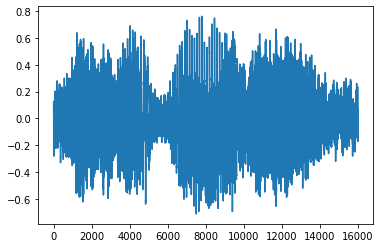

In [12]:
# librosa.output.write_wav('file.wav', audios[4], sr, norm=False)
plt.plot(audios[4])

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers as L
from tensorflow.keras import Model

inp = L.Input((iLen,), name='input')
mel_spec = audioUtils.normalized_mel_spectrogram(inp)
melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalized_spectrogram_model')

melspecModel.summary()

Extension horovod.torch has not been built: /usr/local/lib/python3.9/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-39-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still available.
[2023-01-30 14:17:17.668 tensorflow-2-10-gpu-ml-g4dn-xlarge-b74ae3fe50fe251a3bde3ba27988:2876 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


/usr/local/lib/python3.9/site-packages/smdebug-1.0.21b20221203-py3.9.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/usr/local/lib/python3.9/site-packages/smdebug-1.0.21b20221203-py3.9.egg/smdebug/profiler/system_metrics_reader.py:63: SyntaxWarning: "is not" with a literal. Did you mean "!="?


[2023-01-30 14:17:18.074 tensorflow-2-10-gpu-ml-g4dn-xlarge-b74ae3fe50fe251a3bde3ba27988:2876 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "normalized_spectrogram_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 16000)]      0           []                               
                                                                                                  
 tf.signal.stft (TFOpLambda)    (None, 125, 513)     0           ['input[0][0]']                  
                                                                                                  
 tf.math.abs (TFOpLambda)       (None, 125, 513)     0           ['tf.signal.stft[0][0]']         
                                                  

In [14]:
audios.shape

(32, 16000)

In [15]:
melspec = melspecModel.predict(audios)
melspec.shape

np.min(melspec[9,:,:].T), np.max(melspec[9,:,:].T), np.mean(melspec[9,:,:].T)

1/1 [==============================] - 1s 740ms/step


(-1.9005479, 2.073307, -0.34194225)

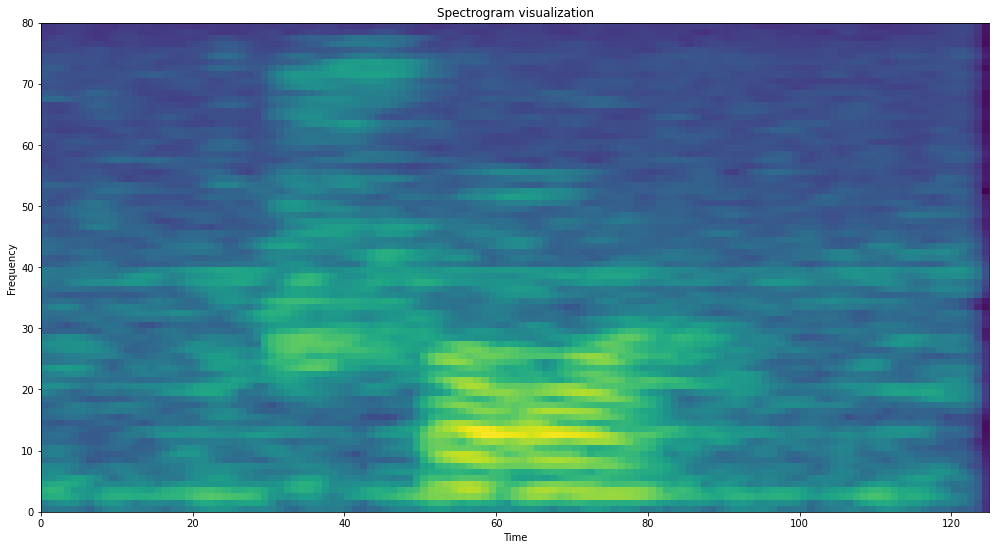

In [16]:
plt.figure(figsize=(17,9))
plt.pcolormesh(melspec[9,:,:].T)

plt.title('Spectrogram visualization')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [17]:
import librosa

# Check if mel spectrogram matches the one computed with librosa
librosa_melspec = librosa.feature.melspectrogram(y=audios[9], sr=sr, n_fft=1024,
                                                 hop_length=128, power=1.0, #window='hann',
                                                 n_mels=80, fmin=40.0, fmax=sr/2)
S_dB = librosa.power_to_db(librosa_melspec, ref=np.max)
np.min(S_dB), np.max(S_dB)

(-51.58742232592788, 0.0)

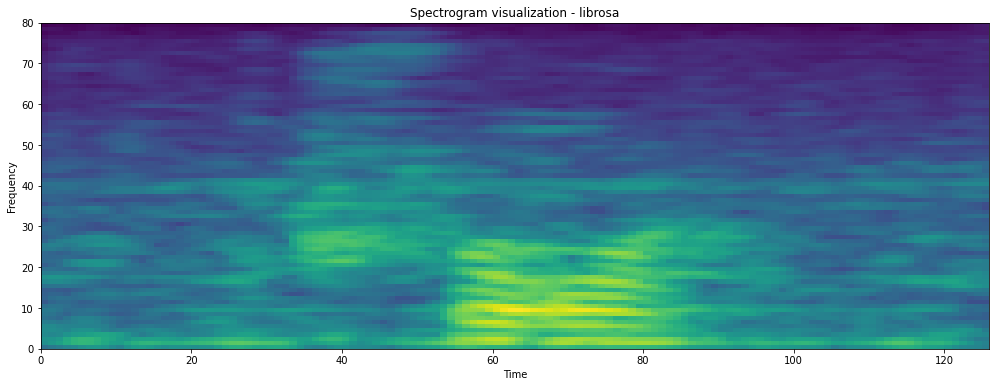

In [18]:
plt.figure(figsize=(17,6))
plt.pcolormesh(S_dB)

plt.title('Spectrogram visualization - librosa')
plt.ylabel('Frequency')
plt.xlabel('Time')

plt.show()

In [19]:
# plt.hist(melspec.flatten(), bins=100)

# Models

Create Keras models to see if the generators are working properly

In [20]:
from tensorflow.keras.models import Model, load_model

In [21]:
model = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 normalized_spectrogram_model (  (None, None, 80)    0           ['input[0][0]']                  
 Functional)                                                                                      
                                                                                                  
 tf.expand_dims (TFOpLambda)    (None, None, 80, 1)  0           ['normalized_spectrogram_model[0]
                                                                 [0]']                            
                                                                                              

In [22]:
# model.load_weights('model-attRNN.h5')

In [23]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,  
            math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

In [24]:
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-attRNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=1,
                    callbacks=[earlystopper, checkpointer, lrate])

model.save('model-attRNN.h5')

Changing learning rate to 0.001
Epoch 1/60
2650/2651 [============================>.] - ETA: 0s - loss: 0.9594 - sparse_categorical_accuracy: 0.7283
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.88887, saving model to model-attRNN.h5
2651/2651 [==============================] - 146s 52ms/step - loss: 0.9592 - sparse_categorical_accuracy: 0.7283 - val_loss: 0.3774 - val_sparse_categorical_accuracy: 0.8889 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/60
2650/2651 [============================>.] - ETA: 0s - loss: 0.3266 - sparse_categorical_accuracy: 0.9035
Epoch 2: val_sparse_categorical_accuracy improved from 0.88887 to 0.91348, saving model to model-attRNN.h5
2651/2651 [==============================] - 74s 28ms/step - loss: 0.3266 - sparse_categorical_accuracy: 0.9035 - val_loss: 0.2903 - val_sparse_categorical_accuracy: 0.9135 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/60
2650/2651 [============================>.] - ETA: 0s - loss: 0.2406 - spars

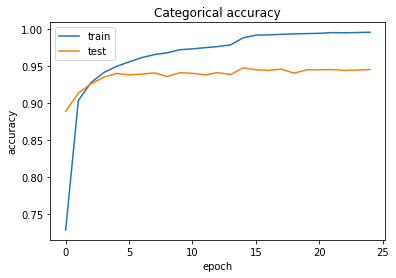

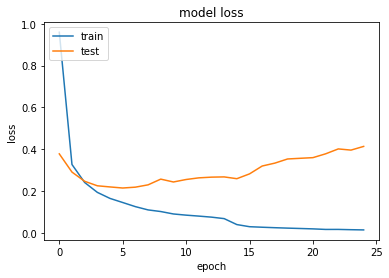

In [25]:
# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
# results.history

In [27]:
# load best model according to cross-validation - model-attRNN
# model = load_model('model-attRNN.h5', custom_objects={'Melspectrogram': Melspectrogram, 'Normalization2D': Normalization2D })
model.load_weights('model-attRNN.h5')

In [28]:
# tf.saved_model.save(model, 'model-KWS-attRNN')

In [29]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [30]:
valEval = model.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
trainEval = model.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
testEval = model.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model.metrics_names, trainEval, valEval, testEval) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.030799511820077896, 0.9913240075111389] 
Validation: [0.25848108530044556, 0.9480506181716919] 
Test: [0.2578895092010498, 0.9421172142028809]


In [31]:
kaggle12cmd = False
if kaggle12cmd:
    #only for the Kaggle competition, 12-cmd
    x_testR, y_testR = testRGen.__getitem__(0)
    testREval = model.evaluate(x_testR, y_testR, verbose=1)
    print(testREval)
    testREval = model.evaluate(testRGen, use_multiprocessing=True, workers=4,verbose=1)
    print(testREval)

## Evaluation and Attention Plots

In [32]:
attSpeechModel = Model(inputs=model.input,
                                 outputs=[model.get_layer('output').output, 
                                          model.get_layer('attSoftmax').output,
                                          model.get_layer('tf.expand_dims').output])


In [33]:
audios, classes = valGen.__getitem__(3)
classes

array([17, 12,  4,  5, 35, 21, 27,  8, 18, 11, 11, 20,  3,  1, 32, 22, 20,
       12,  1, 13, 15, 33, 23,  6, 32,  9, 32,  5, 20, 22, 18,  9])

In [34]:
#8 - on, 13 - one, 7 - right
idAudio = 8
classes[idAudio]

18

In [35]:
outs, attW, specs = attSpeechModel.predict(audios)

1/1 [==============================] - 1s 1s/step


In [36]:
np.argmax(outs,axis=1)

array([17, 12,  4,  5, 35,  5, 27,  8, 18, 16, 11, 20,  3,  1, 32, 22, 20,
       12,  1, 13, 15, 33, 23,  6, 32,  9, 32,  5, 20, 22, 18,  9])

In [37]:
specs.shape

(32, 125, 80, 1)

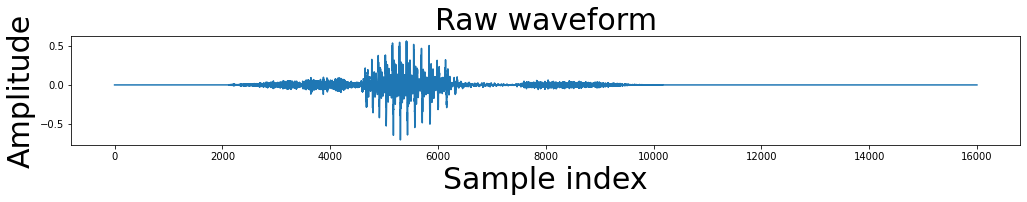

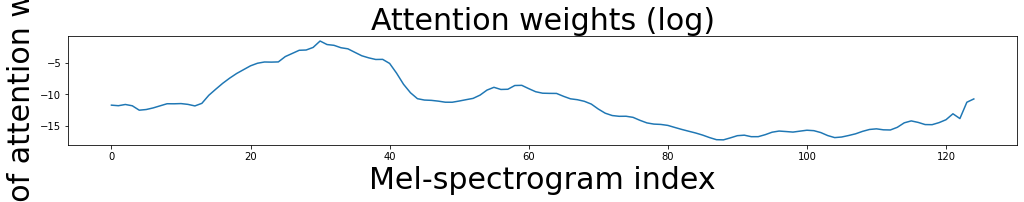

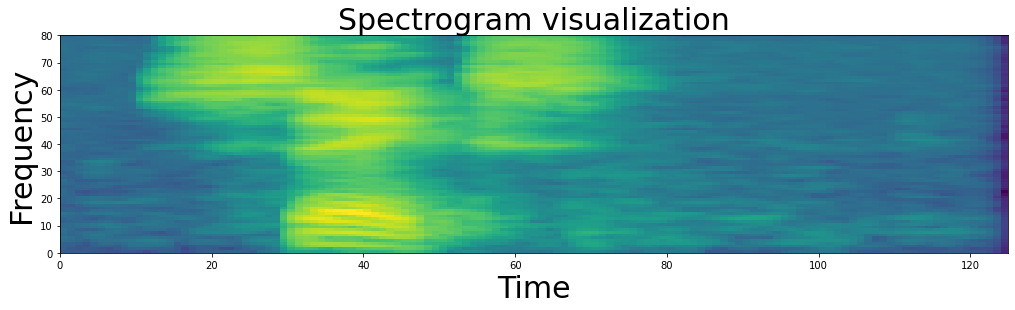

In [38]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw waveform', fontsize=30)
plt.ylabel('Amplitude', fontsize=30)
plt.xlabel('Sample index', fontsize=30)
plt.plot(audios[idAudio])
plt.savefig('picrawWave.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=30)
plt.ylabel('Log of attention weight', fontsize=30)
plt.xlabel('Mel-spectrogram index', fontsize=30)
plt.plot(np.log(attW[idAudio]))
plt.savefig('picAttention.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs[idAudio,:,:,0].T)

plt.title('Spectrogram visualization', fontsize=30)
plt.ylabel('Frequency', fontsize=30)
plt.xlabel('Time', fontsize=30)
plt.savefig('picmelSpec.png', dpi = 400)

plt.show()

In [39]:
y_pred = model.predict(x_test, verbose=1)

344/344 [==============================] - 5s 10ms/step


In [40]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred,1))

In [41]:
#set(y_test)

In [42]:
#35word, v2
classes = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

In [43]:
#35word, v1
#classes=['nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight', 
#         'bed', 'bird', 'cat', 'dog', 'happy', 'house', 
#         'marvin', 'sheila', 'tree', 'wow']

In [44]:
#20cmd
#classes=['unknown', 'nine', 'yes',  'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
#         'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven',  'eight']

Confusion matrix, without normalization


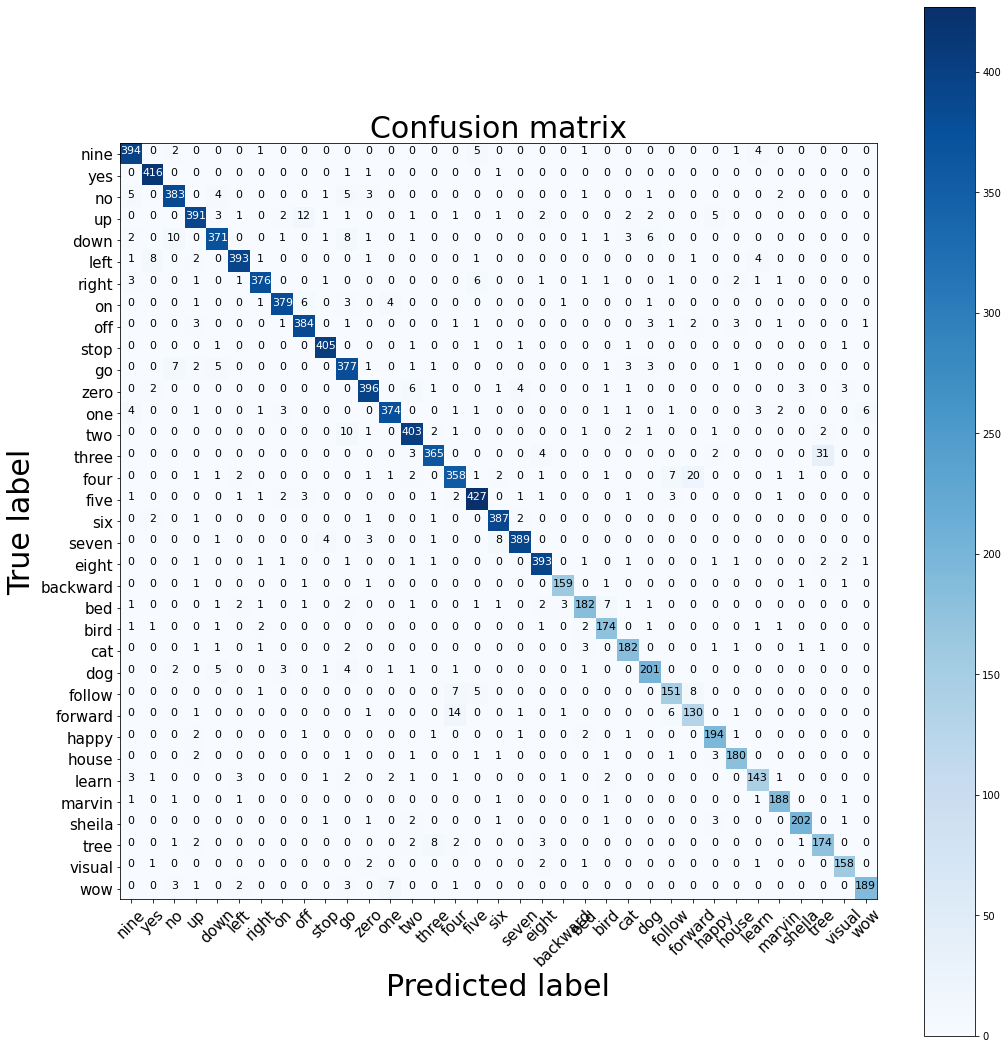

In [45]:
audioUtils.plot_confusion_matrix(cm, classes, normalize=False)

In [46]:
import pandas as pd
[tf.__version__, pd.__version__, librosa.__version__]

['2.10.1', '1.5.2', '0.9.2']

# Save model

In [47]:
model_16000 = SpeechModels.AttRNNSpeechModel(nCategs, samplingrate = sr, inputLength = None)
model_16000.load_weights('model-attRNN.h5')

tf.saved_model.save(model_16000, 'model-KWS-attRNN')

INFO:tensorflow:Assets written to: model-KWS-attRNN/assets


INFO:tensorflow:Assets written to: model-KWS-attRNN/assets


In [48]:
model_16000 = tf.saved_model.load('model-KWS-attRNN')

In [49]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model('model-KWS-attRNN') # path to the SavedModel directory

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the model.
with open('model-KWS-attRNN.tflite', 'wb') as f:
    f.write(tflite_model)